## Table of contents

1 [Markov Chain Monte Carlo (MCMC)](#Markov-Chain-Monte-Carlo-(MCMC))

2 [Least Squares Method](#Least-Squares-Method)

3 [Method comparison](#Method-comparison)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import linearRegression_1
import math
import random

from mcmc import mcmc
import densities
import my_problemLR
from numpy import linalg as lg

%matplotlib notebook


# Markov Chain Monte Carlo (MCMC)

## Parameter for the problem

In [3]:
# parameters for the problem
Npoint = 100

# data abscissa {Xi}
my_problemLR.Xi = np.random.rand(Npoint)
my_problemLR.sigmad = 0.1 # sec

## Linear regression coefficients to be found

In [4]:
slope = 2.
intercept = 1.

## Create "observed data"

In [7]:
#  Data value = {Yi}
my_problemLR.Yi = slope * my_problemLR.Xi + intercept + np.random.randn(Npoint) * my_problemLR.sigmad

## Trial solution

In [8]:
X0 = np.array([10., 10.])

## Run MCMC with Gaussian ('Gaus') and exponential ('Expo') residual distributions

In [14]:
step = np.array([0.01, 0.01])# *2 or *5 or *10

niter = 100000


mout_gauss, mMAP_gauss, accrate_gauss = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                                             densities.generate, densities.logproposal, X0, niter, step, 'Gaus')

mout_exp, mMAP_exp, accrate_exp = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                                          densities.generate, densities.logproposal, X0, niter, step, 'Exp')

## Plot solutions

<IPython.core.display.Javascript object>


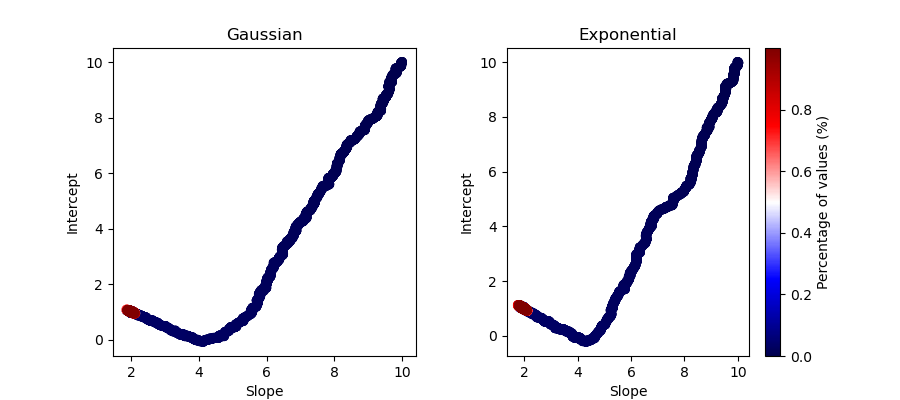

acceptanceRate 0.64816
Solution with highest probability is  [1.98583113 1.00812978]
acceptanceRate 0.70044
Solution with highest probability is  [1.95945705 1.01325265]


In [17]:
x_gauss = mout_gauss[:, 0]
y_gauss = mout_gauss[:, 1]

x_exp = mout_exp[:, 0]
y_exp = mout_exp[:, 1]

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title('Gaussian')
print('acceptanceRate',accrate_gauss)
plt.scatter(x_gauss, y_gauss,cmap= plt.get_cmap('seismic'), c = np.arange(len(x_gauss))/len(x_gauss))
print('Solution with highest probability is ',mMAP_gauss)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.subplot(122)
plt.title('Exponential')
print('acceptanceRate',accrate_exp)
plt.scatter(x_exp, y_exp,cmap= plt.get_cmap('seismic'), c = np.arange(len(x_exp))/len(x_exp))
print('Solution with highest probability is ',mMAP_exp)
plt.xlabel('Slope')
plt.ylabel('Intercept')
cb = plt.colorbar()
cb.set_label('Percentage of values (%)')
plt.subplots_adjust(wspace=0.3)

The chain starts at point (10, 10) and ends around point (2, 2). The color illustrates the density of points. Important is to note the low percentage values until the chain approaches (2, 2). This part is known as the burn-in chain where the chain has not converged to the dense part of the probability distribution yet and is oversampling low probability area. Then, we can see a high density area around the point (2, 2) known as the posterior chain where the chain settled into the equilibrium solution, each step is a sample of the target distribution. We will have to determine the burn-in chain and delete it from the overall chain.

The two chains with Gaussian and exponential residual distributions have very similar paths.

## Defining the burning period

<IPython.core.display.Javascript object>


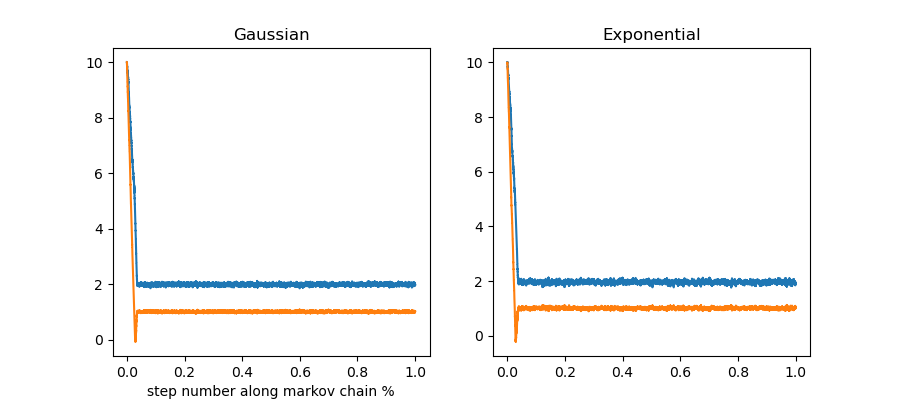

In [19]:
iter=np.arange(0.,niter)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title('Gaussian')
plt.plot(iter/niter, x_gauss,iter/niter,y_gauss)
plt.xlabel('step number along markov chain %')
plt.subplot(122)
plt.title('Exponential')
plt.plot(iter/niter, x_expo,iter/niter,y_expo)

We detect the posterior chain where the above curve stabilises. We chose a threshold of 0.04 to remove the burn-in chain (see below). The same threshold is used for Gaussian and exponential residual distributions.

In [22]:
burning_period = int(0.04*niter)

a_gauss = mout_gauss[burning_period:-1,0]
b_gauss = mout_gauss[burning_period:-1,1]

a_exp = mout_exp[burning_period:-1,0]
b_exp = mout_exp[burning_period:-1,1]

## Defining approximately the correlation length

<IPython.core.display.Javascript object>


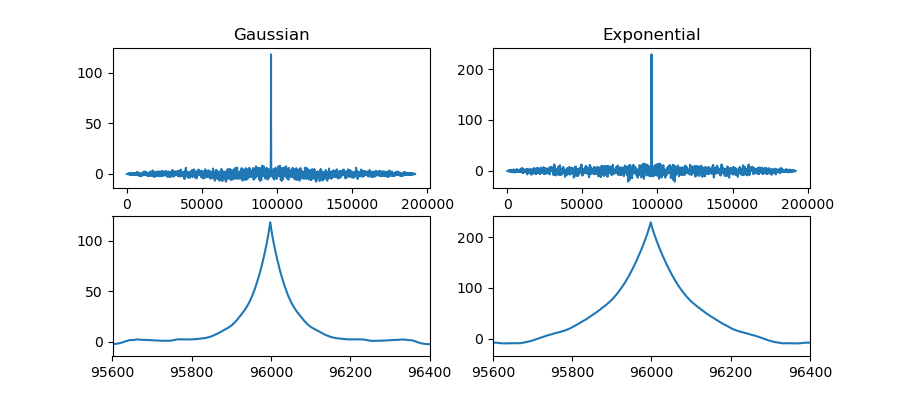

(95600.0, 96400.0)

In [23]:
import scipy.signal as sig

plt.figure(figsize=(9, 4))
plt.subplot(221)
plt.title('Gaussian')
plt.plot(sig.correlate(a_gauss-np.mean(a_gauss),a_gauss-np.mean(a_gauss)))
plt.subplot(223)
plt.plot(sig.correlate(a_gauss-np.mean(a_gauss),a_gauss-np.mean(a_gauss)))
plt.xlim([96000-400, 96000+400])
plt.subplot(222)
plt.title('Exponential')
plt.plot(sig.correlate(a_exp-np.mean(a_exp),a_exp-np.mean(a_exp)))
plt.subplot(224)
plt.plot(sig.correlate(a_exp-np.mean(a_exp),a_exp-np.mean(a_exp)))
plt.xlim([96000-400, 96000+400])

The central peak is approximatively $\pm$200 values wide (correlation length). We wil therefore only take every 200th value. Again, the same value is used for Gaussian and exponential residual distributions.

## Create a "true" Markov-chain after removal of the burning period and after getting rid of correlation

In [24]:
a_gauss_true=a_gauss[0:-1:200]
b_gauss_true=b_gauss[0:-1:200]

a_exp_true=a_exp[0:-1:200]
b_exp_true=b_exp[0:-1:200]

## Represent histogram for slope and intercept

<IPython.core.display.Javascript object>


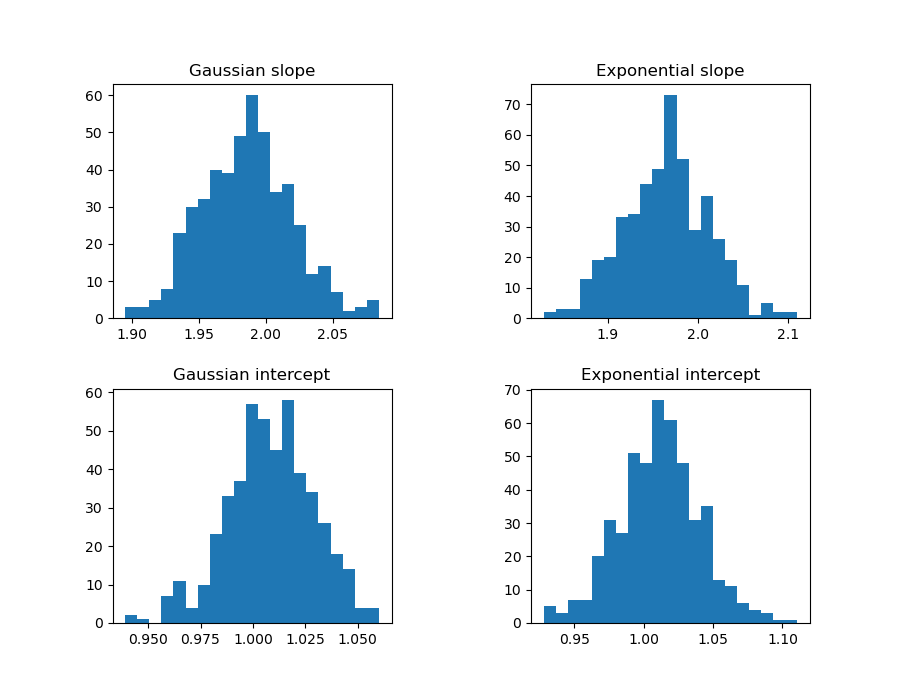

In [26]:
plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.title('Gaussian slope')
ha = plt.hist(a_gauss_true, int(np.sqrt(np.shape(a_gauss_true)[0])))
plt.subplot(223)
plt.title('Gaussian intercept')
hb = plt.hist(b_gauss_true, int(np.sqrt(np.shape(b_gauss_true)[0])))
plt.subplot(222)
plt.title('Exponential slope')
ha = plt.hist(a_exp_true, int(np.sqrt(np.shape(a_exp_true)[0])))
plt.subplot(224)
plt.title('Exponential intercept')
hb = plt.hist(b_exp_true, int(np.sqrt(np.shape(b_exp_true)[0])))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

## Distribution of posterior density function

Here we test different distributions for the posterior density function using the Kolmogorov-Smirnov test.

In [27]:
import scipy.stats as st

def get_best_distribution(data):
    
    dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']
    
    dist_results = []
    
    params = {}
    
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        # print("p value for "+dist_name+" = "+str(p))
        # print('D=%.3f' % D)
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [28]:
print('GAUSSIAN SLOPE:')
gs = get_best_distribution(a_gauss_true)
print('GAUSSIAN INTERCEPT:')
gi = get_best_distribution(b_gauss_true)

GAUSSIAN SLOPE:
Best fitting distribution: norm
Best p value: 0.8621905936474219
Parameters for the best fit: (1.9858100239173742, 0.033746680463858314)
GAUSSIAN INTERCEPT:
Best fitting distribution: beta
Best p value: 0.8633104564184664
Parameters for the best fit: (292.9394347629699, 42.0002984994624, 0.006628057075355742, 1.1453641011210118)


In [30]:
print('EXPONENTIAL SLOPE:')
es = get_best_distribution(a_exp_true)
print('EXPONENTIAL INTERCEPT:')
ei = get_best_distribution(b_exp_true)

EXPONENTIAL SLOPE:
Best fitting distribution: pearson3
Best p value: 0.8175206394798407
Parameters for the best fit: (0.022908855868094203, 1.964738208368909, 0.04701406106682794)
EXPONENTIAL INTERCEPT:
Best fitting distribution: lognorm
Best p value: 0.737254177100124
Parameters for the best fit: (0.016825905883939528, -0.7352672505038866, 1.7459921766240365)


# Least Squares Method

In [37]:
# create artificial data
n = 100
x=np.random.rand(n)
# We want to guess the slope + intercept of the line of equation y=a*x+b
a=2.
b=1.
y = a*x + b + np.random.randn(n)*0.1

In [38]:
x2 = np.array(list(x))
y2 = np.array(list(y))
# plt.figure()
slopes = []
intercepts = []

iters = 1000



for i in range(iters):
    pop = np.random.randint(0,len(x) , size=math.ceil(len(x2)/10))
    x3 = np.delete(x2, pop)
    y3 = np.delete(y2, pop)
    add = np.random.randint(0, len(x3), size = len(x2)-len(x3))
    
    x3 = np.append(x3, x3[add])
    y3 = np.append(y3, y3[add])
    
    # sol=minimize(fun=mycost, x0=np.zeros(2,), args=(x,y, 1), method='Nelder-Mead')

    def getGMatrix(x,order):

        N=len(x)
        G=np.ones((N,order+1))

        for i in range(0,order):

            G[:,i]=x**float(order-i)


        return G

    G=getGMatrix(x3,1)
    Gt=G.transpose()
    rhs=np.matmul(Gt,y3) 
    lhs=np.matmul(Gt,G)
    m=lg.solve(lhs,rhs)
    
    slopes.append(m[0])
    intercepts.append(m[1])
    
    # plt.subplot(121)
    # plt.hist(x3, color='black', alpha=0.1)
    # plt.scatter(i, np.nanmean(x3))
    # plt.subplot(122)
    # plt.hist(y3, color='black', alpha=0.1)
    # plt.scatter(i, np.nanmean(y3))

print(np.mean(y3 - y),
np.mean(x3 - x))
#plt.figure()
#plt.plot(x3,y3, '.')
#plt.plot(x,y, '.')

-0.014895997304966596 -0.008735507207053286


<IPython.core.display.Javascript object>


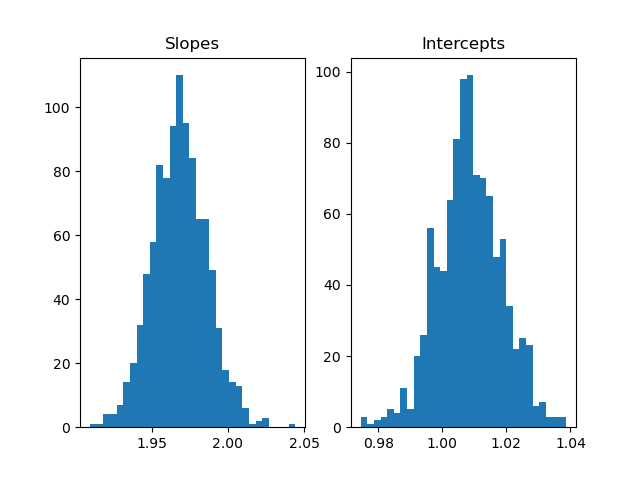

Slope standard deviation: 0.018 , mean : 1.969
Intercept standard deviation: 0.010 , mean : 1.009


In [39]:
plt.figure()
plt.subplot(121)
plt.hist(slopes, bins=int(np.sqrt(iters)))
plt.title('Slopes')
plt.subplot(122)
plt.hist(intercepts, bins=int(np.sqrt(iters)))
plt.title('Intercepts')
print('Slope standard deviation: %.3f' % np.std(slopes), ', mean : %.3f' % np.mean(slopes))
print('Intercept standard deviation: %.3f' % np.std(intercepts), ', mean : %.3f' % np.mean(intercepts))
# plt.savefig('../Output/Hist_LQ.png')

# Method comparison

## Rerun MCMC method on similar data

In [44]:
def MCMC(ind, xt, yt):
    # parameters for the problem
    Npoint = 100

    # data abscissa {Xi}
    my_problemLR.Xi = xt
    my_problemLR.sigmad = 0.1 # sec

    slope = 2.
    intercept = 1.

    #  Data value = {Yi}
    my_problemLR.Yi = yt
    X0 = np.array([10., 10.])
    # set the step Dernier param : 'Gaus' ou autre
    step = np.array([0.01, 0.01])# *2 or *5 or *10

    niter = 100000


    mout, mMAP, accrate = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                               densities.generate, densities.logproposal, X0, niter, step, ind)
    x=mout[:,0]
    y=mout[:,1]

    burning_period = int(0.2*niter)
    a = mout[burning_period:-1,0]
    b = mout[burning_period:-1,1]

    a=a[0:-1:200]
    b=b[0:-1:200]
    return a,b

In [45]:
Tot = ['Gaus', 'Exp']
t = []
for i in Tot:
    t.append(MCMC(i, x, y))

In [46]:
ag, bg = t[0]
ae, be = t[1]
n = len(ae)

In [47]:
SLOP = [slopes, ag, ae]
INTER = [intercepts, bg, be]
labels = ['Least square', 'Gaussian','Exponential']

## Visualisation

<IPython.core.display.Javascript object>


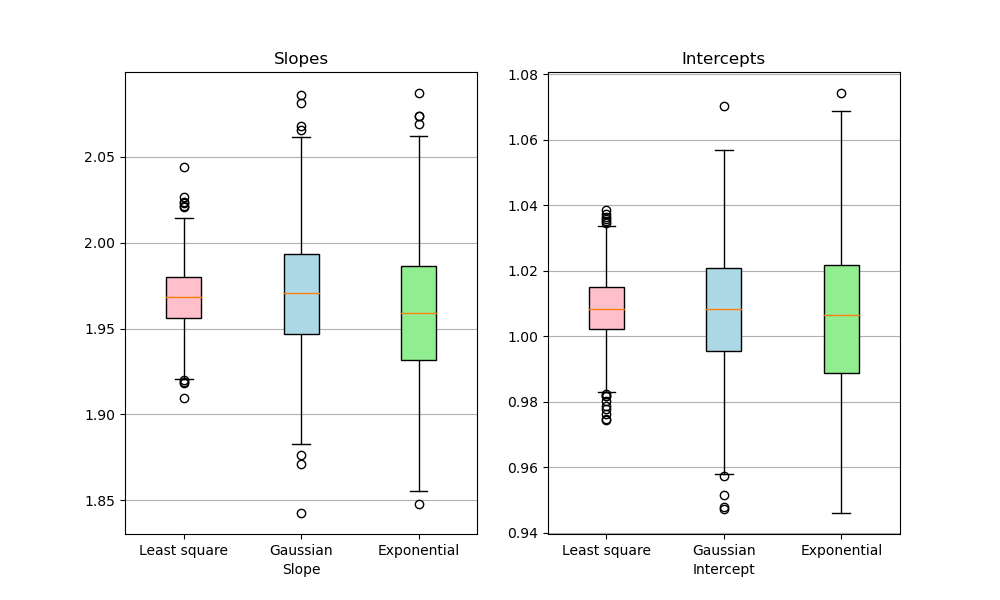

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# rectangular box plot
bplot1 = axes[0].boxplot(SLOP,
                         vert=True,  
                         patch_artist=True, 
                         labels=labels)  
axes[0].set_title('Slopes')


bplot2 = axes[1].boxplot(INTER,
                         vert=True, 
                         patch_artist=True,
                         labels=labels) 
axes[1].set_title('Intercepts')

colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

for ind,ax in enumerate(axes):
    ax.yaxis.grid(True)
    if ind == 0:
        ax.set_xlabel('Slope')
    else:
        ax.set_xlabel('Intercept')

plt.show()